In [1]:
!pip install qiskit qiskit-aer qiskit-ibm-runtime qiskit-machine-learning
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing instal

In [2]:
#import necessary libraries
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeKyiv
from qiskit_aer import AerSimulator
import torch
import math
import pandas as pd
import matplotlib as mpl
import seaborn as sns


Convolutional Layer

In [3]:
def convolutional_layer(qc, weights, qubits, skip_first_layer=True, log=None):
    if len(qubits) < 3:
        raise ValueError("This circuit is too small to apply a convolutional layer!")

    if skip_first_layer:
        # Only use 9 conv parameters: 3 entangling + 6 post U gates
        rxx_theta = weights[6]
        ryy_theta = weights[7]
        rzz_theta = weights[8]
        post_u = weights[9:15]  # 3 per qubit
    else:
        # Use full 15 conv parameters
        pre_u = weights[0:6]   # 3 per qubit
        rxx_theta = weights[6]
        ryy_theta = weights[7]
        rzz_theta = weights[8]
        post_u = weights[9:15]  # 3 per qubit

    for p in [0, 1]:
        for i in range(len(qubits) - 1):
            if i % 2 == p:
                q1 = qubits[i]
                q2 = qubits[i + 1]

                if not skip_first_layer and i % 2 == 0:
                    qc.u(pre_u[0], pre_u[1], pre_u[2], q1)
                    qc.u(pre_u[3], pre_u[4], pre_u[5], q2)

                qc.rxx(rxx_theta, q1, q2)
                qc.ryy(ryy_theta, q1, q2)
                qc.rzz(rzz_theta, q1, q2)

                qc.u(post_u[0], post_u[1], post_u[2], q1)
                qc.u(post_u[3], post_u[4], post_u[5], q2)


Pooling Layer

In [4]:
def pooling_layer(qc, weights, qubits, add_measurements=True):
    """
    Mid-circuit measurement-based pooling with consistent qubit reduction.
    Handles [0,2,4] → [0,4] case explicitly.
    """
    num_q = len(qubits)
    if num_q < 2:
        raise ValueError("Need at least 2 qubits for pooling.")
    if len(weights) != 3:
        raise ValueError("Expected 3 parameters for the U gate.")

    theta, phi, lam = weights
    needed_cbits = num_q // 2

    # Get or create classical register
    c_pool = next((reg for reg in qc.cregs if reg.name == "c_pool"), None)
    if c_pool is None:
        c_pool = ClassicalRegister(needed_cbits, name="c_pool")
        qc.add_register(c_pool)

    # Special case: [0,2,4] → [0,4]
    if num_q == 3:
        mid_qubit = qubits[1]  # qubit 2 (to be dropped)
        q_keep = qubits[0]     # qubit 0 (to be conditionally rotated)
        cbit = c_pool[0]

        if add_measurements:
            qc.measure(mid_qubit, cbit)
            with qc.if_test((cbit, 1)):
                qc.u(theta, phi, lam, q_keep)

        return [qubits[0], qubits[2]]  # ✅ keep 0 and 4

    # General case
    reduced_qubits = []
    for i in range(1, num_q, 2):
        q_keep = qubits[i - 1]
        q_drop = qubits[i]
        cbit = c_pool[i // 2]

        if add_measurements:
            qc.measure(q_drop, cbit)
            with qc.if_test((cbit, 1)):
                qc.u(theta, phi, lam, q_keep)

        reduced_qubits.append(q_keep)

    return reduced_qubits

Amplitude encoding the feature vector

In [5]:
def amplitude_embedding_block(features: np.ndarray, num_qubits: int, pad_with=0.5, label="AmpEmbed"):
    """
    Create a subcircuit that prepares a state with amplitudes equal to the normalized feature vector.
    This mimics PennyLane's AmplitudeEmbedding.
    """

    # ✅ Ensure features is a NumPy array
    feat = np.asarray(features, dtype=np.float64)

    # ✅ Check if `feat` is still a scalar
    if feat.ndim == 0:
        raise ValueError(f"`features` should be an array, but got a scalar: {features}")


    # Ensure the feature vector has the correct length
    dim = 2 ** num_qubits

    if len(feat) < dim:
        feat = np.concatenate([feat, np.full(dim - len(feat), pad_with)])
    elif len(feat) > dim:
        raise ValueError(f"Feature length {len(feat)} exceeds 2^{num_qubits} = {dim}.")

    # Normalize
    norm = np.linalg.norm(feat) + 1e-10
    feat = feat / norm

    # Create a circuit and use the initialize method to prepare the state exactly
    encoding_circuit = QuantumCircuit(num_qubits, name=label)
    encoding_circuit.initialize(feat, list(range(num_qubits)))

    encoding_circuit.barrier()
    return encoding_circuit.to_instruction()


Combining the convolution and pooling action

In [6]:
def conv_and_pooling(
    qc,
    kernel_weights,
    qubits,
    skip_first_layer=True,
    add_measurements=True
):
    """
    Applies convolution + pooling using either full (18) or reduced (12) param kernels,
    based on skip_first_layer flag.
    """
    if skip_first_layer:
       if len(kernel_weights) != 18:
           raise ValueError("Expected 18 parameters (6 dummy + 9 used + 3 pool).")
       conv_core = kernel_weights[6:15]  # 3 entangling + 6 post-U
       conv_params = np.concatenate([np.zeros(6), conv_core])  # Prepend 6 dummy
       pool_params = kernel_weights[15:18]


    else:
        if len(kernel_weights) != 18:
            raise ValueError("Expected 18 parameters (15 conv + 3 pool) for the first layer.")
        conv_params = kernel_weights[:15]
        pool_params = kernel_weights[15:]

    if len(qubits) < 2:
        raise ValueError("At least 2 qubits are required for conv_and_pooling.")

    # Apply conv
    convolutional_layer(qc, conv_params, qubits, skip_first_layer=skip_first_layer)

    # Apply pooling
    updated_qubits = pooling_layer(qc, pool_params, qubits, add_measurements=add_measurements)

    qc.barrier(*updated_qubits)

    return updated_qubits

Defining the dense layer

In [7]:
import pennylane as qml
import numpy as np

# A 2-qubit device just to obtain the matrix
dev_2q = qml.device("default.qubit", wires=2)

@qml.qnode(dev_2q)
def arbitrary_su4_qnode(params):
    qml.ArbitraryUnitary(params, wires=[0, 1])
    return qml.state()
def get_su4_matrix(params):
    # qml.matrix(...) transforms a QNode to return the overall operator
    op_matrix = qml.matrix(arbitrary_su4_qnode)(params)
    return op_matrix  # This will be a (4,4) complex NumPy array

from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit

def create_dense_layer_gate(params):
    # Get the 4x4 matrix from PennyLane
    U_dense = get_su4_matrix(params)
    # Create a Qiskit UnitaryGate
    return UnitaryGate(U_dense)

def dense_gate(qc, last_layer_unitary, q0, q1):
    # If user passes a 4x4 matrix directly
    if isinstance(last_layer_unitary, np.ndarray) and last_layer_unitary.shape == (4, 4):
        gate = UnitaryGate(last_layer_unitary)
    else:
        # Otherwise, assume it's a 15-parameter array
        gate = create_dense_layer_gate(last_layer_unitary)

    qc.append(gate, [q0, q1])
    qc.barrier(q0, q1)

In [8]:
def qcnn_circuit(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits=6
):
    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = QuantumCircuit(num_qubits)
    all_qubits = list(range(num_qubits))

    # 2) Amplitude embedding
    embed_gate = amplitude_embedding_block(features, num_qubits, pad_with=0.5, label="AmpEmbed")
    qc.append(embed_gate, qargs=all_qubits)

    # 3) Convolution + Pooling
    layers = layers = len(weights)
    qubits_in_use = all_qubits.copy()

    for layer_idx in range(layers):
        if len(qubits_in_use) <= 2:
            break

        kernel_weights = weights[layer_idx]
        skip = layer_idx != 0
        qubits_in_use = conv_and_pooling(qc, kernel_weights, qubits_in_use, skip_first_layer=skip)

    # 4) Final Dense Layer
    if len(qubits_in_use) != 2:
        raise ValueError(f"After pooling, expected exactly 2 qubits, got {len(qubits_in_use)}.")

    if 0 not in qubits_in_use:
        raise ValueError(f"Final qubits do not include q0: {qubits_in_use}")

    # Ensure q0 is first
    if qubits_in_use[1] == 0:
        qubits_in_use = [qubits_in_use[1], qubits_in_use[0]]

    # ✅ Use PennyLane's ArbitraryUnitary → Qiskit's UnitaryGate wrapper
    dense_gate(qc, last_layer_unitary, qubits_in_use[0], qubits_in_use[1])

    return qc, qubits_in_use

Load the digits dataset

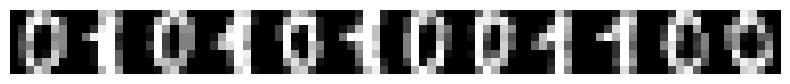

In [9]:
# Load the digits dataset (has 1797 images of 8x8 pixels by default)
digits = datasets.load_digits()
images, labels = digits.data, digits.target

# Filter out only the digits 0 and 1
mask = (labels == 0) | (labels == 1)
images = images[mask]
labels = labels[mask]

# Optional: visualize the first few images
fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(8, 1))
for i, ax in enumerate(axes):
    ax.imshow(images[i].reshape(8, 8), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


Extract data only for labels 0 and 1 and ramdomly split the dataset to train/test

In [10]:
def load_digits_data(num_train, num_test, rng=None):
    """
    Return training and testing data from the 8x8 digits dataset,
    but restricted to digits 0 and 1 only.

    Args:
        num_train (int): Number of training samples to draw.
        num_test (int): Number of testing samples to draw.
        rng (np.random.Generator or None): A NumPy random generator.
            If None, a default generator with a fixed seed is used.

    Returns:
        x_train (np.ndarray): Training feature vectors.
        y_train (np.ndarray): Training labels (0 or 1).
        x_test (np.ndarray): Testing feature vectors.
        y_test (np.ndarray): Testing labels (0 or 1).
    """
    # If no RNG is provided, use a default
    if rng is None:
        rng = np.random.default_rng(seed=42)

    # Load the digits dataset
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # Keep only digits 0 and 1
    mask = (labels == 0) | (labels == 1)
    features = features[mask]
    labels = labels[mask]

    # **Standardize the features**
    #scaler = StandardScaler()
    #features = scaler.fit_transform(features)  # Apply standardization

    # Normalize each feature vector (L2 norm = 1)
    norms = np.linalg.norm(features, axis=1, keepdims=True) + 1e-10
    features = features / norms

    # Get indices per class
    indices_0 = np.where(labels == 0)[0]
    indices_1 = np.where(labels == 1)[0]

    # Determine how many per class
    if num_train % 2 == 0:
        n_0 = n_1 = num_train // 2
    else:
        # Randomly decide which class gets 1 more
        if rng.integers(0, 2) == 0:
            n_0, n_1 = num_train // 2 + 1, num_train // 2
        else:
            n_0, n_1 = num_train // 2, num_train // 2 + 1

    # Sample training indices
    train_0 = rng.choice(indices_0, size=n_0, replace=False)
    train_1 = rng.choice(indices_1, size=n_1, replace=False)
    train_indices = np.concatenate([train_0, train_1])
    rng.shuffle(train_indices)

    # Sample test indices from the remaining
    remaining_indices = np.setdiff1d(np.arange(len(labels)), train_indices)
    test_indices = rng.choice(remaining_indices, size=num_test, replace=False)

    x_train = features[train_indices]
    y_train = labels[train_indices]
    x_test = features[test_indices]
    y_test = labels[test_indices]

    return x_train, y_train, x_test, y_test

Define qcnn_probability, a lower-level function that handles the quantum circuit construction, transpilation, execution, and post-processing to get probabilities.

In [11]:
def qcnn_probability(weights, weights_last, features, labels, num_qubits=6, shots=256, use_fakekyiv=True, epoch=None):
    """
    Calculate probability of measuring the given label for a batch of feature vectors.

    Args:
        weights (ndarray): QCNN layer weights.
        weights_last (ndarray): Final 2-qubit (or dense layer) weights.
        features (ndarray): Feature vectors (input data).
        labels (ndarray): Expected output labels (0 or 1).
        num_qubits (int): Number of qubits in the QCNN.
        shots (int): Number of shots for execution.
        use_fakekyiv (bool): If True, run on FakeKyiv (hardware-simulated) instead of AerSimulator.

    Returns:
        np.ndarray: Array of probabilities for each input feature.
    """
    # ✅ Choose backend (AerSimulator for QASM execution)
    backend = FakeKyiv() if use_fakekyiv else AerSimulator(method="automatic")

    circuits = []
    for feat in features:
        qc, active_qubits = qcnn_circuit(weights, weights_last, feat, num_qubits)

        # ✅ Ensure active_qubits is correct
        #print(f"✅ Final active qubits before last layer: {active_qubits}")

        # ✅ Ensure classical register exists
        if not qc.cregs:
            creg = ClassicalRegister(1)  # One classical bit only
            qc.add_register(creg)
        else:
            creg = qc.cregs[0]

        # Remove any auto-added measurements from previous runs
        qc.remove_final_measurements()

        # ✅ Measure only the first active qubit (qubit 0)
        qc.measure(active_qubits[0], creg[0])
        #print(f"✅ Measuring only qubit {active_qubits[0]} into classical bit 0")

        circuits.append(transpile(qc, backend))  # ✅ Transpile all circuits before execution

    # ✅ Run all circuits in batch
    job = backend.run(circuits, shots=shots)

    try:
        results = job.result()
    except Exception as e:
        raise RuntimeError(f"❌ Qiskit Job Execution Failed: {str(e)}")

    p_correct = []
    all_counts = []  # ✅ Store all measurement counts

    for i, result in enumerate(results.results):
        try:
            counts = result.data.counts  # ✅ Handle missing counts safely

            if counts is None:
               #print(f"⚠️ Warning: Sample {i} has no counts recorded!")
               continue

            all_counts.append(counts)  # ✅ Store for visualization
            #epoch_str = f"Epoch {epoch+1}, " if epoch is not None else ""
            #print(f"🚀 {epoch_str}Sample {i}: Raw counts = {counts}")

        except AttributeError as e:
            raise RuntimeError(f"❌ Result format error: {str(e)}\nResult Object: {result}")

        total_shots = sum(counts.values())

        # ✅ Extracting only the first qubit measurement
        counts_single_qubit = {"0": 0, "1": 0}
        for bitstring, count in counts.items():
            first_bit = bitstring[-1]  # Extract only the last bit (qubit 0 result)
            counts_single_qubit[first_bit] += count

        # ✅ Compute probability of correct classification (only qubit 0 matters)
        label = labels[i] if isinstance(labels, np.ndarray) else labels
        label_counts = counts_single_qubit[str(label)]  # Use single-character keys

        p_correct.append(label_counts / total_shots if total_shots > 0 else 0.0)

    #print(f"✅ Final probability array: {p_correct} (sum check: {sum(p_correct):.4f})")

    # 🔥 Visualization Calls
    #plot_measurement_counts(all_counts, epoch)
    #plot_probability_distribution(np.array(p_correct))

    return np.array(p_correct)

Define compute_out, a clean and validated call to qcnn_probability that returns a NumPy array of per-sample correct classification probabilities.

In [12]:
def compute_out(weights, weights_last, features, labels, num_qubits=6, shots=256, epoch=None, use_fakekyiv=True):
    """
    Computes the probability of correct classification using batch execution.
    """
    features = np.atleast_2d(features)
    labels = np.atleast_1d(labels)

    # ✅ Use qcnn_probability() for batch execution
    probabilities = qcnn_probability(
        weights=weights,
        weights_last=weights_last,
        features=features,
        labels=labels,
        num_qubits=num_qubits,
        shots=shots,
        use_fakekyiv=use_fakekyiv,
        epoch=epoch
    )

    # ✅ Debugging Output
    #for i, (x, y, p_correct) in enumerate(zip(features, labels, probabilities)):
        #print(f"🚀 Sample {i}: Feature = {x}")
        #print(f"🔍 Sample {i}: Label = {y}")
        #print(f"🎯 Sample {i}: Computed probability → p_correct={p_correct:.4f}")

    return probabilities

In [13]:
def compute_accuracy(weights, weights_last, features, labels, num_qubits=6, shots=256, epoch=None, use_fakekyiv=True):
    """
    Classify by thresholding p_correct > 0.5, then compare with true label.
    """
    # ✅ Ensure features & labels are correct format
    features = np.atleast_2d(features)
    labels = np.atleast_1d(labels)

    p = compute_out(weights, weights_last, features, labels, num_qubits, shots=shots, epoch=epoch, use_fakekyiv=use_fakekyiv)

    # ✅ Ensure p has same length as labels
    if len(p) != len(labels):
        raise ValueError(f"Mismatch: p.shape={p.shape}, labels.shape={labels.shape}")

    # Predicted label = 1 if p[i] >= 0.5 else 0
    preds = (p >= 0.5).astype(int)

    return np.mean(preds == labels)


def compute_cost(weights, weights_last, features, labels, num_qubits=6, shots=256, epoch=None, use_fakekyiv=True):
    """
    Computes binary cross-entropy loss:
    L = -mean[y·log(p) + (1 - y)·log(1 - p)]
    """
    features = np.atleast_2d(features)
    labels = np.atleast_1d(labels)

    # Predicted probabilities
    p = compute_out(weights, weights_last, features, labels, num_qubits, shots=shots, epoch=epoch, use_fakekyiv=use_fakekyiv)

    # Clip predictions to avoid log(0)
    eps = 1e-10
    p = np.clip(p, eps, 1 - eps)

    # Cross-entropy loss
    loss = -np.mean(labels * np.log(p) + (1 - labels) * np.log(1 - p))

    return loss



In [14]:
def init_weights(rng=None):
    """
    Initialize weights to exactly match PennyLane QCNN architecture:
    - Layer 0: 15 conv + 3 pool = 18 parameters
    - Layer 1: 9 conv + 3 pool = 12 parameters
    - Final dense SU(4) layer: 15 parameters

    Returns:
        Tuple[List[np.ndarray], np.ndarray]:
            - List of kernel weights (layer-wise)
            - Dense layer weights (15,)
    """
    if rng is None:
        rng = np.random.default_rng()

    # Layer 0: full 15 conv + 3 pool
    layer0 = rng.normal(loc=0.0, scale=1.0, size=18)

    # Layer 1 (and beyond): skip first layer → only 9 conv + 3 pool
    layer1 = rng.normal(loc=0.0, scale=1.0, size=18)

    conv_pool_weights = [layer0, layer1]

    # Final dense SU(4) layer: 15 parameters
    weights_last = rng.normal(loc=0.0, scale=1.0, size=15)

    return conv_pool_weights, weights_last

Define training function

In [15]:
import torch
import math
import numpy as np
from sklearn.metrics import confusion_matrix

def cosine_decay(epoch, max_epochs, initial_lr, alpha):
    cosine_decay = 0.5 * (1 + math.cos(math.pi * epoch / max_epochs))
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_lr * decayed

def train_qcnn_adam(n_train, n_test, n_epochs, shots=256, lr=0.1, alpha=0.95, rng=None):
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    weights, weights_last = init_weights()
    len_layer0, len_layer1, len_dense = 18, 18, 15

    flat_params = np.concatenate([weights[0], weights[1], weights_last])
    params = torch.tensor(flat_params, dtype=torch.float32, requires_grad=True)

    # Log initial parameter values here:
    initial_params = params.detach().cpu().numpy().copy()

    optimizer = torch.optim.Adam([params], lr=lr)
    train_costs, test_costs, train_accs, test_accs, lrs = [], [], [], [], []

    for epoch in range(n_epochs):
        # === Learning rate schedule ===
        new_lr = cosine_decay(epoch, n_epochs, initial_lr=lr, alpha=alpha)
        for g in optimizer.param_groups:
            g["lr"] = new_lr
        lrs.append(new_lr)

        # === Finite difference gradients ===
        grad = torch.zeros_like(params)
        eps = 0.05

        with torch.no_grad():
            for i in range(len(params)):
                params[i] += eps
                w_plus = params.detach().cpu().numpy()
                idx = 0
                w0 = w_plus[idx:idx+len_layer0]; idx += len_layer0
                w1 = w_plus[idx:idx+len_layer1]; idx += len_layer1
                w_dense_plus = w_plus[idx:]
                cost_plus = compute_cost([w0, w1], w_dense_plus, x_train, y_train, shots=shots)

                params[i] -= 2 * eps
                w_minus = params.detach().cpu().numpy()
                idx = 0
                w0 = w_minus[idx:idx+len_layer0]; idx += len_layer0
                w1 = w_minus[idx:idx+len_layer1]; idx += len_layer1
                w_dense_minus = w_minus[idx:]
                cost_minus = compute_cost([w0, w1], w_dense_minus, x_train, y_train, shots=shots)

                grad[i] = (cost_plus - cost_minus) / (2 * eps)
                params[i] += eps

        optimizer.zero_grad()
        params.grad = grad
        torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
        optimizer.step()

        # === Evaluation ===
        with torch.no_grad():
            w_np = params.cpu().numpy()
            idx = 0
            w0 = w_np[idx:idx+len_layer0]; idx += len_layer0
            w1 = w_np[idx:idx+len_layer1]; idx += len_layer1
            w_dense = w_np[idx:]
            weights_list = [w0, w1]

            # 🚀 Compute once per split
            train_probs = compute_out(weights_list, w_dense, x_train, y_train, shots=shots, use_fakekyiv=True)
            test_probs = compute_out(weights_list, w_dense, x_test, y_test, shots=shots, use_fakekyiv=True)

        # ✅ Accuracy
        train_preds = (train_probs >= 0.5).astype(int)
        test_preds = (test_probs >= 0.5).astype(int)
        train_acc = np.mean(train_preds == y_train)
        test_acc = np.mean(test_preds == y_test)

        # ✅ Cross-entropy loss
        eps = 1e-10
        train_probs_clipped = np.clip(train_probs, eps, 1 - eps)
        test_probs_clipped = np.clip(test_probs, eps, 1 - eps)
        train_cost = -np.mean(y_train * np.log(train_probs_clipped) + (1 - y_train) * np.log(1 - train_probs_clipped))
        test_cost = -np.mean(y_test * np.log(test_probs_clipped) + (1 - y_test) * np.log(1 - test_probs_clipped))

        # === Logging ===
        train_costs.append(train_cost)
        test_costs.append(test_cost)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(
            f"Epoch {epoch+1}/{n_epochs} | "
            f"LR = {new_lr:.5f} | "
            f"Train Cost = {train_cost:.4f}, Train Acc = {train_acc:.3f} | "
            f"Test Cost = {test_cost:.4f}, Test Acc = {test_acc:.3f}"
        )

    final_params = params.detach().cpu().numpy().copy()

    return {
        "step": np.arange(1, n_epochs + 1, dtype=int),
        "train_cost": train_costs,
        "train_acc": train_accs,
        "test_cost": test_costs,
        "test_acc": test_accs,
        "lr": lrs,
    }


Run training iterations for different training sizes

> Add blockquote



In [16]:
# Define parameters
n_test = 1
n_epochs = 1
n_reps = 1  # Number of times to repeat training for stability

def run_iterations(n_train):
    """
    Runs `n_reps` training sessions for a given `n_train` size and stores results.
    Optimized by using a list to store results before creating a DataFrame.

    Args:
        n_train (int): Number of training examples.
        shots (int): Number of shots for QASM simulation (FakeKyiv-compatible).

    Returns:
        pd.DataFrame: Training results with cost, accuracy, and step information.
    """
    results_list = []  # Use a list instead of repeatedly concatenating DataFrames

    print(f"Training started for N={n_train}")

    for rep in range(n_reps):
        print(f"Running repetition {rep+1}/{n_reps} for N={n_train}...")

        results = train_qcnn_adam(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
        results.pop("optimizer_result", None)

        df_results = pd.DataFrame.from_dict(results)
        df_results["n_train"] = n_train
        results_list.append(df_results)  # Store results in a list

    print(f"Training finished for N={n_train}")

    return pd.concat(results_list, axis=0, ignore_index=True)  # Final concatenation after loop

# Define multiple training sizes
train_sizes = [2]

# First training size
results_df = run_iterations(n_train=train_sizes[0])

# Loop over remaining sizes
for n_train in train_sizes[1:]:
    results_df = pd.concat([results_df, run_iterations(n_train=n_train)], ignore_index=True)

# ✅ Final dataset ready for analysis
print("Training completed for all sizes!")

Training started for N=2
Running repetition 1/1 for N=2...
Epoch 1/1 | LR = 0.10000 | Train Cost = 0.6363, Train Acc = 1.000 | Test Cost = 0.6107, Test Acc = 1.000
Training finished for N=2
Training completed for all sizes!


Plot the training results

/tmp/ipython-input-808802565.py:58: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log', base=2)


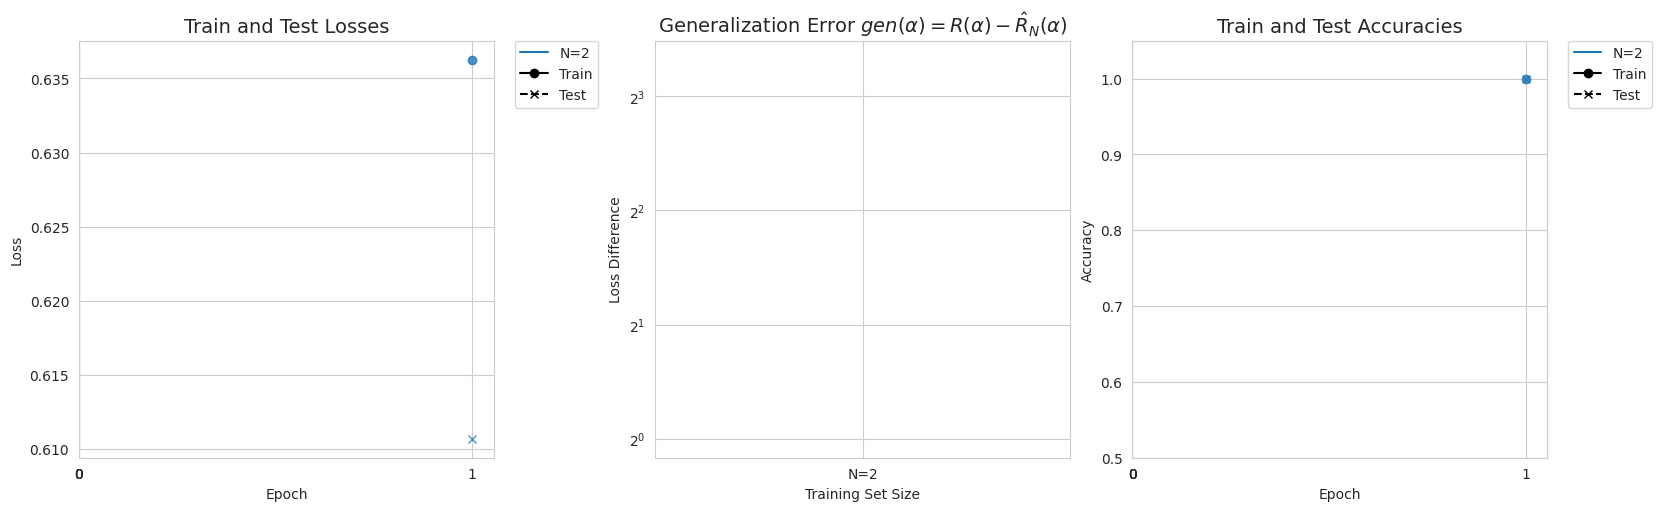

In [17]:
# Apply Seaborn styling
sns.set_style('whitegrid')

# Drop the 'optimizer_result' column before grouping
results_df_numeric = results_df.drop(columns=["optimizer_result"], errors='ignore')
df_agg = results_df_numeric.groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()

# Define colors using seaborn color palette
colors = sns.color_palette()

# Set up matplotlib figure
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5), constrained_layout=True)

generalization_errors = []

# Plot losses and accuracies for each training size
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train].copy()

    # Ensure no zero or negative values in cost data before applying log scale
    train_cost_mean = df[('train_cost', 'mean')]
    test_cost_mean = df[('test_cost', 'mean')]

    dfs = [train_cost_mean, test_cost_mean,
           df[('train_acc', 'mean')], df[('test_acc', 'mean')]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0, 0, 2, 2]  # Allocate plot positions

    # Plot for train and test losses and accuracies
    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df['step'], dfs[k], lines[k], label=labels[k],
                markevery=10, color=colors[i], alpha=0.8)

    # Plot final loss difference (generalization error) using last epoch dynamically
    last_epoch = df[df['step'] == df['step'].max()]
    gen_error = last_epoch[('test_cost', 'mean')].values[0] - last_epoch[('train_cost', 'mean')].values[0]
    generalization_errors.append(gen_error)

# Format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#ax.set_yscale('log')  # Log scale for losses
ax.set_xticks(np.linspace(0, df['step'].max(), num=5, dtype=int))  # Ensure even spacing on x-axis

# Format generalization error plot
ax = axes[1]
ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
ax.set_xticks(train_sizes)
ax.set_xticklabels([f"N={n}" for n in train_sizes])
ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Loss Difference')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # horizontal line at zero
ax.set_yscale('log', base=2)


# Format accuracy plot
ax = axes[2]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)
ax.set_xticks(np.linspace(0, df['step'].max(), num=5, dtype=int))  # Ensure even spacing on x-axis

# Create a separate legend for Train/Test markers
legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='black')
]

# Add to both Train/Test Loss and Accuracy plots
axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1, fontsize=10)
axes[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1, fontsize=10)

plt.show()


Parameter matched CNN

✓ finished N=  2 rep=0
✓ finished N=  2 rep=1
✓ finished N=  2 rep=2
✓ finished N=  2 rep=3
✓ finished N=  2 rep=4
✓ finished N=  2 rep=5
✓ finished N=  2 rep=6
✓ finished N=  2 rep=7
✓ finished N=  2 rep=8
✓ finished N=  2 rep=9
✓ finished N=  2 rep=10
✓ finished N=  2 rep=11
✓ finished N=  2 rep=12
✓ finished N=  2 rep=13
✓ finished N=  2 rep=14
✓ finished N=  2 rep=15
✓ finished N=  2 rep=16
✓ finished N=  2 rep=17
✓ finished N=  2 rep=18
✓ finished N=  2 rep=19
✓ finished N=  2 rep=20
✓ finished N=  2 rep=21
✓ finished N=  2 rep=22
✓ finished N=  2 rep=23
✓ finished N=  2 rep=24
✓ finished N=  2 rep=25
✓ finished N=  2 rep=26
✓ finished N=  2 rep=27
✓ finished N=  2 rep=28
✓ finished N=  2 rep=29
✓ finished N=  2 rep=30
✓ finished N=  2 rep=31
✓ finished N=  2 rep=32
✓ finished N=  2 rep=33
✓ finished N=  2 rep=34
✓ finished N=  2 rep=35
✓ finished N=  2 rep=36
✓ finished N=  2 rep=37
✓ finished N=  2 rep=38
✓ finished N=  2 rep=39
✓ finished N=  2 rep=40
✓ finished N=  2 rep=41
✓ 

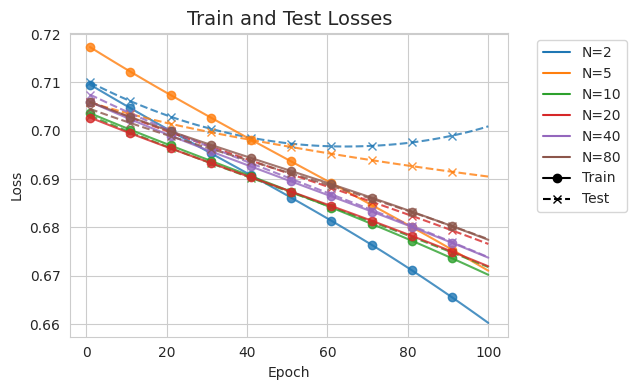

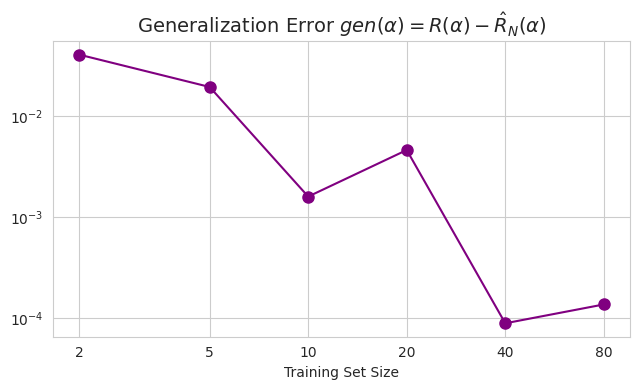

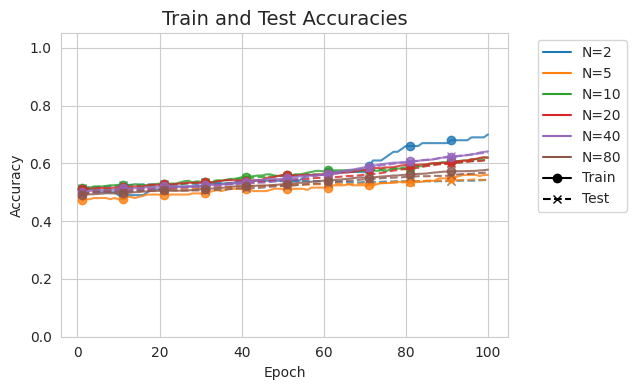

In [18]:
# =============================================================
# 0.  Imports & global config
# =============================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set_style("whitegrid")
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------------
# 1.  45-parameter CNN
# -------------------------------------------------------------
class DigitCNN45(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=True)   # 40
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Linear(4, 1, bias=True)                             # 5

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)

# -------------------------------------------------------------
# 2.  Helper: draw balanced train / free test
# -------------------------------------------------------------
def sample_digits01(n_train, n_test, rng):
    digits = datasets.load_digits()
    X, y   = digits.data, digits.target
    mask   = (y == 0) | (y == 1)
    X, y   = X[mask], y[mask]

    idx0, idx1 = np.where(y == 0)[0], np.where(y == 1)[0]

    # balanced train
    n0 = n_train // 2 + (n_train % 2)      # 0 gets the “extra” if odd
    n1 = n_train // 2
    tr_idx0 = rng.choice(idx0, n0, replace=False)
    tr_idx1 = rng.choice(idx1, n1, replace=False)
    train_idx = np.concatenate([tr_idx0, tr_idx1])
    rng.shuffle(train_idx)

    # unbalanced test
    remaining = np.setdiff1d(np.arange(len(y)), train_idx)
    test_idx  = rng.choice(remaining, n_test, replace=False)

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

# -------------------------------------------------------------
# 3.  Train once & log every epoch
# -------------------------------------------------------------
def run_one_fit(X_tr, y_tr, X_te, y_te,
                epochs=50, lr=1e-3, rep=0, n_train=0):

    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr).reshape(-1, 1, 8, 8)
    X_te = scaler.transform(X_te).reshape(-1, 1, 8, 8)

    X_tr_t = torch.tensor(X_tr, dtype=torch.float32, device=device)
    y_tr_t = torch.tensor(y_tr.reshape(-1,1), dtype=torch.float32, device=device)
    X_te_t = torch.tensor(X_te, dtype=torch.float32, device=device)
    y_te_t = torch.tensor(y_te.reshape(-1,1), dtype=torch.float32, device=device)

    model = DigitCNN45().to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    lossf = nn.BCELoss()

    log_rows = []

    for epoch in range(1, epochs+1):
        # ---- optimisation step ----
        opt.zero_grad()
        loss = lossf(model(X_tr_t), y_tr_t)
        loss.backward()
        opt.step()

        # ---- log metrics ----
        with torch.no_grad():
            tr_out = model(X_tr_t)
            te_out = model(X_te_t)

            tr_loss = lossf(tr_out, y_tr_t).item()
            te_loss = lossf(te_out, y_te_t).item()
            tr_acc  = ((tr_out >= 0.5).float() == y_tr_t).float().mean().item()
            te_acc  = ((te_out >= 0.5).float() == y_te_t).float().mean().item()

        log_rows.append({
            "n_train": n_train,
            "rep": rep,
            "step": epoch,
            "train_cost": tr_loss,
            "test_cost":  te_loss,
            "train_acc":  tr_acc,
            "test_acc":   te_acc,
        })

    return log_rows

# -------------------------------------------------------------
# 4.  Main sweep
# -------------------------------------------------------------
train_sizes = [2, 5, 10, 20, 40, 80]
n_test      = 100
reps        = 50
rng_master  = np.random.default_rng(42)

all_rows = []
for N in train_sizes:
    for r in range(reps):
        rng = np.random.default_rng(rng_master.integers(0, 2**32))
        Xtr, ytr, Xte, yte = sample_digits01(N, n_test, rng)
        rows = run_one_fit(Xtr, ytr, Xte, yte, epochs=100,
                           lr=1e-3, rep=r, n_train=N)
        all_rows.extend(rows)
        print(f"✓ finished N={N:>3} rep={r}")

# -------------------------------------------------------------
# 5.  Save & convert to DataFrame
# -------------------------------------------------------------
df = pd.DataFrame(all_rows)
#csv_path = "cnn_digits01_learningcurve.csv"
#df.to_csv(csv_path, index=False)
#print(f"\nCSV saved to → {csv_path}")

# =============================================================
# 6.  PLOT (Split into 3 separate PNGs)
# =============================================================

# --- aggregate mean & std across reps ---
selected_sizes = train_sizes
df_plot = df[df["n_train"].isin(selected_sizes)]

df_agg = (
    df_plot
    .groupby(["n_train", "step"])
    .agg(["mean", "std"])
    .reset_index()
)
df_agg.columns = ['_'.join(c).strip('_') for c in df_agg.columns.values]

colors = sns.color_palette()
generalization_errors = []

# --- 1. Loss plot ---
fig_loss, ax_loss = plt.subplots(figsize=(6.5, 4))
for i, N in enumerate(selected_sizes):
    d = df_agg[df_agg["n_train"] == N]
    steps = d["step"]
    train_loss = d["train_cost_mean"]
    test_loss = d["test_cost_mean"]
    ax_loss.plot(steps, train_loss, "o-", label=fr"$N={N}$", color=colors[i], alpha=0.8, markevery=10)
    ax_loss.plot(steps, test_loss, "x--", color=colors[i], alpha=0.8, markevery=10)

ax_loss.set_title("Train and Test Losses", fontsize=14)
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.legend(
    handles=[
        *[mpl.lines.Line2D([0], [0], label=f"N={n}", color=colors[i]) for i, n in enumerate(selected_sizes)],
        mpl.lines.Line2D([0], [0], marker="o", ls="-", label="Train", color="black"),
        mpl.lines.Line2D([0], [0], marker="x", ls="--", label="Test", color="black")
    ],
    loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True
)
fig_loss.tight_layout()
fig_loss.savefig("cnn_loss.png", dpi=300, bbox_inches="tight")
print("✅ Saved cnn_loss.png")

# --- 2. Generalization Error plot ---
fig_gen, ax_gen = plt.subplots(figsize=(6.5, 4))
for i, N in enumerate(selected_sizes):
    d = df_agg[df_agg["n_train"] == N]
    last = d[d["step"] == 100]
    gen_err = last["test_cost_mean"].values[0] - last["train_cost_mean"].values[0]
    generalization_errors.append(gen_err)

# Plot log-log
mag = np.abs(generalization_errors)
sign = np.sign(generalization_errors)
ax_gen.loglog(selected_sizes, mag, color='purple', linewidth=1.5)
for n, m, s in zip(selected_sizes, mag, sign):
    marker = "o" if s >= 0 else "v"
    ax_gen.loglog(n, m, marker=marker, color='purple', markersize=8)

ax_gen.set_xscale('log', base=2)
ax_gen.set_yscale('log')
ax_gen.set_xticks(selected_sizes, labels=[str(n) for n in selected_sizes])
ax_gen.set_title(r"Generalization Error $gen(\alpha)=R(\alpha)-\hat{R}_N(\alpha)$", fontsize=14)
ax_gen.set_xlabel("Training Set Size")
fig_gen.tight_layout()
fig_gen.savefig("cnn_generror.png", dpi=300, bbox_inches="tight")
print("✅ Saved cnn_generror.png")

# --- 3. Accuracy plot ---
fig_acc, ax_acc = plt.subplots(figsize=(6.5, 4))
for i, N in enumerate(selected_sizes):
    d = df_agg[df_agg["n_train"] == N]
    steps = d["step"]
    train_acc = d["train_acc_mean"]
    test_acc = d["test_acc_mean"]
    ax_acc.plot(steps, train_acc, "o-", label=fr"$N={N}$", color=colors[i], alpha=0.8, markevery=10)
    ax_acc.plot(steps, test_acc, "x--", color=colors[i], alpha=0.8, markevery=10)

ax_acc.set_title("Train and Test Accuracies", fontsize=14)
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_ylim(0, 1.05)
ax_acc.legend(
    handles=[
        *[mpl.lines.Line2D([0], [0], label=f"N={n}", color=colors[i]) for i, n in enumerate(selected_sizes)],
        mpl.lines.Line2D([0], [0], marker="o", ls="-", label="Train", color="black"),
        mpl.lines.Line2D([0], [0], marker="x", ls="--", label="Test", color="black")
    ],
    loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True
)
fig_acc.tight_layout()
fig_acc.savefig("cnn_accuracy.png", dpi=300, bbox_inches="tight")
print("✅ Saved cnn_accuracy.png")

# --- Generalisation error table ---
gen_err_series = pd.Series(generalization_errors,
                           index=selected_sizes, name="gen_error")
print("\nGeneralisation error (test − train cost @ final epoch)")
print(gen_err_series.to_string(float_format="%.6f"))


Building a classical CNN

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [20]:
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)  # simulate 1st quantum layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                # pooling

        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)  # simulate 2nd quantum layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(8 * 2 * 2, 2)  # output layer

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x


In [22]:
!pip install torchviz

In [23]:
from torchviz import make_dot
from torch import rand
model = ClassicalCNN()
x = rand(1, 1, 8, 8)
y = model(x)
make_dot(y, params=dict(model.named_parameters())).render("cnn_graph", format="png")


'cnn_graph.png'

In [24]:
def load_digits_classical(n_train, n_test, rng=None):
    digits = datasets.load_digits()
    X = digits.images
    y = digits.target

    mask = (y == 0) | (y == 1)
    X = X[mask]
    y = y[mask]

    X = X / 16.0  # normalize [0, 1]
    X = X.reshape(-1, 1, 8, 8).astype('float32')  # reshape for CNN

    if rng is None:
        rng = np.random.default_rng(seed=42)

    indices = np.arange(len(y))
    train_indices = rng.choice(indices, size=n_train, replace=False)
    remaining = np.setdiff1d(indices, train_indices)
    test_indices = rng.choice(remaining, size=n_test, replace=False)

    return X[train_indices], y[train_indices], X[test_indices], y[test_indices]


In [25]:
def train_classical_cnn(n_train, n_test, epochs=20, lr=0.01):
    x_train, y_train, x_test, y_test = load_digits_classical(n_train, n_test)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ClassicalCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    x_train_tensor = torch.tensor(x_train).to(device)
    y_train_tensor = torch.tensor(y_train).long().to(device)
    x_test_tensor = torch.tensor(x_test).to(device)
    y_test_tensor = torch.tensor(y_test).long().to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Eval
        model.eval()
        with torch.no_grad():
            test_output = model(x_test_tensor)
            test_pred = test_output.argmax(dim=1)
            test_acc = (test_pred == y_test_tensor).float().mean().item()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Test Acc: {test_acc:.3f}")

    return model


In [26]:

# Fixed evaluation parameters
n_test = 100
n_epochs = 100
n_reps = 100  # Set to >1 if you want to average over repetitions

def run_classical_iterations(n_train):
    """
    Train the classical CNN for a given training size `n_train`.
    Records training loss and test accuracy for each epoch.

    Returns:
        pd.DataFrame: Training metrics per epoch.
    """
    results_list = []
    print(f"Classical CNN training started for N={n_train}")

    for rep in range(n_reps):
        print(f"Running repetition {rep+1}/{n_reps} for N={n_train}...")

        x_train, y_train, x_test, y_test = load_digits_classical(n_train, n_test)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ClassicalCNN().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        x_train_tensor = torch.tensor(x_train).to(device)
        y_train_tensor = torch.tensor(y_train).long().to(device)
        x_test_tensor = torch.tensor(x_test).to(device)
        y_test_tensor = torch.tensor(y_test).long().to(device)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(x_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                test_output = model(x_test_tensor)
                test_pred = test_output.argmax(dim=1)
                test_acc = (test_pred == y_test_tensor).float().mean().item()
                test_loss = criterion(test_output, y_test_tensor).item()
                train_pred = output.argmax(dim=1)
                train_acc = (train_pred == y_train_tensor).float().mean().item()

                # ✅ Print here
                print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {loss.item():.4f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

            results_list.append({
                "step": epoch + 1,
                "train_loss": loss.item(),
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_loss": test_loss,
                "n_train": n_train,
            })

    print(f"Training finished for N={n_train}")
    return pd.DataFrame(results_list)


In [27]:
# Classical CNN loop
train_sizes = [2, 5, 10, 20, 40, 80]
results_classical_df = run_classical_iterations(train_sizes[0])

for n_train in train_sizes[1:]:
    df = run_classical_iterations(n_train)
    results_classical_df = pd.concat([results_classical_df, df], ignore_index=True)

print("Classical CNN training completed for all sizes!")


Streaming output truncated to the last 5000 lines.
Epoch 52/100 | Train Loss: 0.0003 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 53/100 | Train Loss: 0.0003 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 54/100 | Train Loss: 0.0003 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 55/100 | Train Loss: 0.0003 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 56/100 | Train Loss: 0.0003 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 57/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 58/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 59/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 60/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 61/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 62/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 63/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 64/100 | Train Loss: 0.0002 | Train Acc: 1.000 | Test Acc: 1.000
Epoch 65/100 | Train Loss:

It takes approximately 1 min 38 sec for the training to complete!

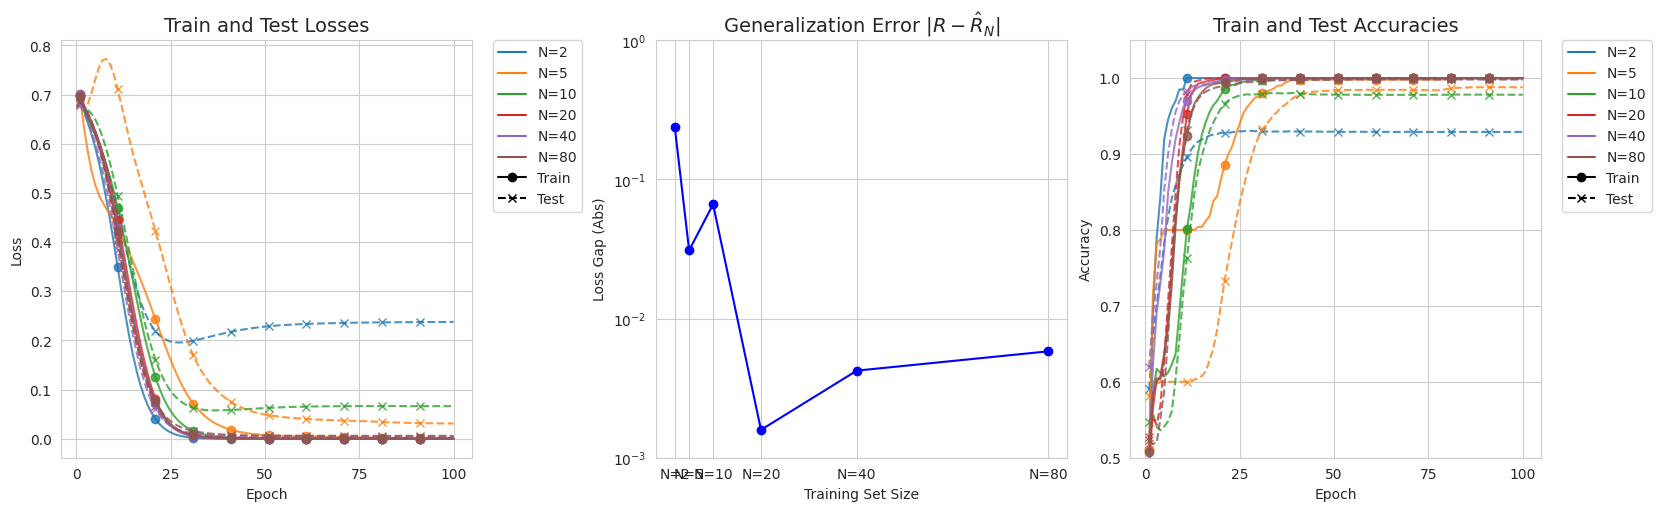

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

# Group and aggregate mean and std
results_df = results_classical_df.copy()
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()

colors = sns.color_palette()
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5), constrained_layout=True)

generalization_errors = []

# Plot losses and accuracies for each training size
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train].copy()

    # Extract metrics
    train_loss_mean = df[('train_loss', 'mean')]
    test_loss_mean = df[('test_loss', 'mean')]  # Placeholder to match label
    train_acc_mean = df[('train_acc', 'mean')]
    test_acc_mean = df[('test_acc', 'mean')]

    dfs = [train_loss_mean, test_loss_mean,
           train_acc_mean, test_acc_mean]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0, 0, 2, 2]

    # Plot
    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df['step'], dfs[k], lines[k], label=labels[k],
                markevery=10, color=colors[i], alpha=0.8)

    # Generalization error
    last_epoch = df[df['step'] == df['step'].max()]
    gen_error = last_epoch[('test_loss', 'mean')].values[0] - last_epoch[('train_loss', 'mean')].values[0]
    generalization_errors.append(abs(gen_error))  # abs for positive diff

# ---- Format loss plot ----
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xticks(np.linspace(0, df['step'].max(), num=5, dtype=int))

# Compute and clip generalization errors for better visualization
generalization_errors_clipped = [max(1e-3, g) for g in generalization_errors]

# Re-plot generalization error on the middle axis
axes[1].clear()
axes[1].plot(train_sizes, generalization_errors_clipped, "o-", color='blue', label=r"$gen(\alpha)$")
axes[1].set_xticks(train_sizes)
axes[1].set_xticklabels([f"N={n}" for n in train_sizes])
axes[1].set_title(r'Generalization Error $|R - \hat{{R}}_N|$', fontsize=14)
axes[1].set_xlabel('Training Set Size')
axes[1].set_ylabel('Loss Gap (Abs)')
axes[1].set_yscale('log')  # base 10 by default
axes[1].set_ylim(1e-3, 1)  # Set y-limits for clarity
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# ---- Accuracy plot ----
ax = axes[2]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)
ax.set_xticks(np.linspace(0, df['step'].max(), num=5, dtype=int))

# ---- Legend ----
legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='black')
]

axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1, fontsize=10)
axes[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1, fontsize=10)

plt.show()
